# Analyse des données de la campagne - JMS 2025

Ce notebook permet d'expérimenter et analyser des données de la campagne de labellisation.

In [2]:
import os
import s3fs

import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List

In [3]:
def load_excel_from_fs(fs, file_path):
    """Load an Excel file from the file system."""
    try:
        with fs.open(file_path) as f:
            return pd.read_excel(f, dtype=str)
    except Exception as e:
        logging.error(f"Failed to load file {file_path}: {e}")
        raise

    
def format_mapping_table(mapping_table: str) -> str:
    columns_mapping = {
        "NAFold-code\n(code niveau sous-classe de la nomenclature actuelle)": "naf08_niv5",
        "NACEold-code\n(niveau classe)": "naf08_niv4",
        "NAFold-intitulé\n(niveau sous-classe)": "lib_naf08_niv5",
        "NACEnew-code\n(niveau classe)": "naf25_niv4",
        "NAFnew-code\n(code niveau sous-classe de la nomenclature 2025, correspondance logique avec les NAFold-codes)": "naf25_niv5",
        "NAFnew-intitulé\n(niveau sous-classe)": "lib_naf25_niv5",
    }

    return (
        mapping_table.iloc[:, [1, 3, 2, 10, 5, 11]]
        .rename(columns=columns_mapping)
        .assign(
            naf08_niv5=mapping_table.iloc[:, 1],
            naf08_niv4=mapping_table.iloc[:, 3],
            naf25_niv4=mapping_table.iloc[:, 5],
            naf25_niv5=mapping_table.iloc[:, 10],
        )
        .copy()
    )


def clean_dots_simple(
    df: pd.DataFrame, 
    exclude_cols: List[str] = None
) -> pd.DataFrame:
    """
    Supprime les points '.' des colonnes de type 'object' (chaînes de caractères) 
    dans un DataFrame, en excluant les colonnes spécifiées.
    """
    cols_to_clean = df.select_dtypes(include='object').columns
    if exclude_cols:
        cols_to_clean = [col for col in cols_to_clean if col not in exclude_cols]
        
    df.loc[:, cols_to_clean] = df[cols_to_clean].apply(
        lambda col: col.str.replace('.', '', regex=False)
    )
    
    return df

In [4]:
fs = s3fs.S3FileSystem(
        client_kwargs={"endpoint_url": os.getenv("S3_ENDPOINT")},
        key=os.getenv("AWS_ACCESS_KEY_ID"),
        secret=os.getenv("AWS_SECRET_ACCESS_KEY"),
    )

In [71]:
annotated_data = pd.read_parquet('s3://projet-ape/label-studio/annotation-campaign-2024/rev-NAF2025/preprocessed/training_data_NAF2025.parquet', filesystem=fs)
unclassifiable_data = pd.read_parquet('s3://projet-ape/label-studio/annotation-campaign-2024/rev-NAF2025/preprocessed/unclassifiable_data_NAF2025.parquet', filesystem=fs)

NAF_mapping = load_excel_from_fs(fs,'s3://projet-ape/NAF-revision/table-correspondance-naf2025.xls')
NAF_mapping = format_mapping_table(NAF_mapping)
NAF_mapping = clean_dots_simple(NAF_mapping)

NAF_mapping_agg_niv5 = NAF_mapping.groupby('naf08_niv5')['naf25_niv5'].agg(list).reset_index()
NAF_mapping_agg_niv5.rename(columns={'naf25_niv5': 'liste_naf25_niv5'}, inplace=True)
NAF_mapping_agg_niv4 = NAF_mapping.groupby(['naf08_niv4', 'naf08_niv5'])['naf25_niv4'].agg(lambda x: list(set(x))).reset_index()
NAF_mapping_agg_niv4.rename(columns={'naf25_niv4': 'liste_naf25_niv4'}, inplace=True)
# Calcule la longueur des listes (Complexité). Retourne 0 si la colonne n'est pas une liste (e.g., NaN)
NAF_mapping_agg_niv5['len_naf25_niv5'] = NAF_mapping_agg_niv5['liste_naf25_niv5'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )
NAF_mapping_agg_niv4['len_naf25_niv4'] = NAF_mapping_agg_niv4['liste_naf25_niv4'].apply(
        lambda x: len(x) if isinstance(x, list) else 0
    )

# Zoom sur les correspondances

In [76]:
def calculer_frequence_mapping(
    df_mapping: pd.DataFrame, 
    colonne_longueur: str = 'len_naf25_niv5'
) -> pd.DataFrame:
    """
    Calcule la distribution de fréquence (table 1-to-N) pour la colonne de longueur spécifiée 
    dans un DataFrame de mapping NAF.
    """
    
    frequence_df = df_mapping[colonne_longueur].value_counts().reset_index()
    frequence_df.columns = ['1-to-N', 'Occurrences']
    frequence_df = frequence_df.sort_values(by='1-to-N', ascending=True).reset_index(drop=True)
    print(f"Tableau de Fréquence des Correspondances ({colonne_longueur}) :")
    return frequence_df

def df_to_qmd(df: pd.DataFrame, titre: str = "Distribution des codes multivoques") -> str:
    """
    Convertit un DataFrame Pandas en une chaîne formatée Quarto Markdown (qmd).
    """
    
    # Utilise la méthode to_markdown() de Pandas
    markdown_table = df.to_markdown(index=False, floatfmt=".4f")
    
    # Concatène le titre et le tableau
    output = f"### {titre}\n\n"
    output += markdown_table
    
    return output

In [78]:
dist_mapping_niv5 = calculer_frequence_mapping(NAF_mapping_agg_niv5, 'len_naf25_niv5')
dist_mapping_niv4 = calculer_frequence_mapping(NAF_mapping_agg_niv4, 'len_naf25_niv4')

Tableau de Fréquence des Correspondances (len_naf25_niv5) :
Tableau de Fréquence des Correspondances (len_naf25_niv4) :


In [81]:
print(df_to_qmd(dist_mapping_niv5))
print(df_to_qmd(dist_mapping_niv4))

### Distribution des codes multivoques

|   1-to-N |   Occurrences |
|---------:|--------------:|
|   1.0000 |      551.0000 |
|   2.0000 |      109.0000 |
|   3.0000 |       30.0000 |
|   4.0000 |       24.0000 |
|   5.0000 |        6.0000 |
|   6.0000 |        4.0000 |
|   8.0000 |        1.0000 |
|   9.0000 |        2.0000 |
|  21.0000 |        1.0000 |
|  27.0000 |        1.0000 |
|  36.0000 |        1.0000 |
|  38.0000 |        2.0000 |
### Distribution des codes multivoques

|   1-to-N |   Occurrences |
|---------:|--------------:|
|   1.0000 |      573.0000 |
|   2.0000 |      101.0000 |
|   3.0000 |       28.0000 |
|   4.0000 |       15.0000 |
|   5.0000 |        3.0000 |
|   6.0000 |        5.0000 |
|   7.0000 |        1.0000 |
|   8.0000 |        1.0000 |
|  17.0000 |        1.0000 |
|  25.0000 |        1.0000 |
|  29.0000 |        1.0000 |
|  30.0000 |        2.0000 |


## Difficulté et nombre de multivoques: un lien pas si immédiat

On enrichit la table par la liste des correspondances multivoques pour étudier le lien entre multiplicité de la correspondance et la difficulté de la tâche.

Pourquoi ?

Pour illustrer et observer un peu plus finement que l'assertion 
"ça va être compliqué pour les experts particulièrement parce qu'on a des cas où on a beaucoup de multivoques" est à remettre en perspective, à l'aide des données fournies par les gestionnaires sur leur ressenti.

Il y a une illusion de difficulté car avoir davantage de choix peut parfois faciliter la tâche de l'annotation. De même, il y a aussi une illusion de facilité. La difficulté ne peut s'expliquer  sur la simple base du nombre de multivoques.

Objectif: montrer quelques réflexions qu'on peut se poser dans une campagne similaire et objectiver la charge. 

In [ ]:
def enrichir_naf(
    data: pd.DataFrame,
    map_niv5: pd.DataFrame,
    map_niv4: pd.DataFrame,
    naf_col: str = 'NAF2008_code'
) -> pd.DataFrame:
    """
    Joint les données (DATA) avec les mappings NAF 2025 (Niv 5 et Niv 4) 
    et calcule la complexité (longueur des listes) pour chaque observation.

    Effectue deux jointures successives pour ajouter les colonnes 'liste_naf25_niv5' 
    et 'liste_naf25_niv4', puis calcule leur longueur respective dans 'len_naf25_niv5' 
    et 'len_naf25_niv4'.
    """
    
    # Créer une copie pour travailler sans modifier l'original
    df = data.copy()

    # --- Jointure 1 : NAF 2025 Niv 5 ---
    df = pd.merge(
        df,
        map_niv5,
        left_on=naf_col, 
        right_on='naf08_niv5',
        how='left'
    )

    # --- Jointure 2 : NAF 2025 Niv 4 ---
    df = pd.merge(
        df,
        map_niv4,
        left_on=naf_col, 
        right_on='naf08_niv5',
        how='left'
    )

    # --- Nettoyage et Calcul de la Complexité ---
    
    # Supprime les colonnes de jointure redondantes ('naf08_niv5') ajoutées par Pandas
    df = df.drop(columns=[
        'naf08_niv5_x',
        'naf08_niv5_y'
    ], errors='ignore')

    return df

In [27]:
data = enrichir_naf(annotated_data, NAF_mapping_agg_niv5, NAF_mapping_agg_niv4)
unclassifiable_data = enrichir_naf(unclassifiable_data, NAF_mapping_agg_niv5, NAF_mapping_agg_niv4)

In [7]:
print(data[data['len_naf25_niv5']==1]['NAF2008_code'].unique())
len(data[data['len_naf25_niv5']==1])

['4391B' '4719B' '4520B' '4719A' '8510Z' '2611Z']


184

In [8]:
NAF_mapping_agg_niv5[NAF_mapping_agg_niv5['liste_naf25_niv5'].apply(lambda x: '4712H' in x)]

,naf08_niv5,liste_naf25_niv5
441,4719B,[4712H]
479,4789Z,"[4712H, 4740Y, 4752H, 4753Y, 4754Y, 4755G, 475..."
480,4791A,"[4711L, 4712H, 4791Y, 4792H, 4792J]"
482,4799A,"[4711L, 4712H, 4721Y, 4722Y, 4723Y, 4724Y, 472..."
483,4799B,"[4711L, 4712H, 4721Y, 4722Y, 4723Y, 4724Y, 472..."


## Stats

In [ ]:
def calculer_stats_difficulte(
    data_enrichee: pd.DataFrame,
    seuil_difficulte: int = 3,
    len_min_multivoque: int = 1,
    valeur_defaut_rating: int = 1
):
    """
    Filtre les données, calcule les statistiques agrégées (Moyenne, Médiane, Proportion de Difficulté) 
    en fonction de la complexité du mapping (longueur des listes NAF 2025).
    """
    
    # Créer une copie pour le traitement
    stats_data = data_enrichee.copy()

    # --- Étape 1 : Filtrage des Données ---
    
    # 1. Filtre des cas où len_naf25_niv5 est > len_min_multivoque (pour se concentrer sur les multivoques)
    # Note: Le filtre len_naf25_niv5 > 1 dans votre code exclut les 1:1 (len=1).
    stats_data = stats_data[stats_data['len_naf25_niv5'] != len_min_multivoque].copy()
    
    # 2. Filtre de la valeur par défaut du rating (bruit/non-réponse)
    stats_data = stats_data[stats_data['rating'] != valeur_defaut_rating].copy()

    # Si le DataFrame est vide après filtrage, retourner des DataFrames vides
    if stats_data.empty:
        print("Avertissement: DataFrame vide après le filtrage.")
        cols = ['len', 'Moyenne', 'Mediane', 'Part_difficiles']
        return pd.DataFrame(columns=cols), pd.DataFrame(columns=cols)

    # --- Étape 2 : Création de la Variable Binaire de Difficulté ---
    stats_data['is_difficult'] = stats_data['rating'].apply(
        lambda r: 1 if r >= seuil_difficulte else 0
    )

    # --- Étape 3 : Agrégation pour le Niveau 5 ---
    stats_niv5 = stats_data.groupby('len_naf25_niv5').agg(
        Moyenne_Rating=('rating', 'mean'), 
        Mediane_Rating=('rating', 'median'),
        Proportion_Difficulte=('is_difficult', 'mean')
    ).reset_index()

    # Renommage
    stats_niv5.columns = ['len', 'Moyenne', 'Mediane', 'Part_difficiles']

    # --- Étape 4 : Agrégation pour le Niveau 4 ---
    stats_niv4 = stats_data.groupby('len_naf25_niv4').agg(
        Moyenne_Rating=('rating', 'mean'), 
        Mediane_Rating=('rating', 'median'),
        Proportion_Difficulte=('is_difficult', 'mean')
    ).reset_index()
    
    # Renommage
    stats_niv4.columns = ['len', 'Moyenne', 'Mediane', 'Part_difficiles']

    return stats_niv5, stats_niv4

In [30]:
stats_niv5, stats_niv4 = calculer_stats_difficulte(data)
stats_niv5_unc_data, stats_niv4_unc_data = calculer_stats_difficulte(unclassifiable_data)

## Plots

In [63]:
def plot_rating_vs_len(stats_df, title_level, longueurs_pics):
    """Trace la moyenne et la médiane du rating en fonction de la longueur."""
    
    # Configuration du style Seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(10, 6))
    
    # 1. Tracé de la Moyenne (mettez l'accent sur celle-ci)
    sns.lineplot(x='len', y='Moyenne', data=stats_df, marker='o', 
                 label='Moyenne', linewidth=3, color='#1f77b4')

    # 2. Tracé de la Médiane (très pertinent car moins sensible aux outliers)
    sns.lineplot(x='len', y='Mediane', data=stats_df, marker='D', 
                 label='Médiane', linestyle='-', linewidth=2, color='#9467bd')

    # --- AJOUT DYNAMIQUE DES LIGNES VERTICALES ET ANNOTATIONS ---
    max_y_value = stats_df[['Moyenne', 'Mediane']].values.max()
    
    for i, pic_len in enumerate(longueurs_pics):
        # 1. Dessiner la ligne verticale
        plt.axvline(x=pic_len, color='red', linestyle='--', linewidth=1.5, alpha=0.6, 
                    # Afficher le label de légende seulement pour la première ligne
                    label='Pics de Difficulté' if i == 0 else None)
        
        # 2. Annoter la ligne
        plt.text(pic_len, 
                 max_y_value * 0.95 - (i % 2) * (max_y_value * 0.08), # Position Y alternée pour éviter le chevauchement
                 f'len={pic_len}', 
                 color='red', 
                 fontsize=10, 
                 fontweight='bold',
                 ha='center')

    # Titres et étiquettes
    plt.title(f'Difficulté brute vs Multiplicité 1:N des multivoques {title_level}', 
              fontsize=16, fontweight='bold')
    plt.xlabel(f"N correspondances multivoques en NAF 2025 {title_level}", fontsize=12)
    plt.ylabel("Difficulté ressentie (échelle de 0 à 5)", fontsize=12)
    plt.legend(title='Statistique', title_fontsize='11')
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()


def identifier_pics_dynamiques(
    stats_df: pd.DataFrame,
    colonne_a_analyser: str = 'Mediane',
    ecart_type_multiplicateur: float = 1.0,
    seuil_fixe: float = None
) -> List[int]:
    """
    Identifie les longueurs de liste (abscisses) qui représentent des "pics" 
    dans une colonne de métriques (Moyenne ou Médiane) en se basant sur un seuil.

    Args:
        stats_df: DataFrame contenant les statistiques agrégées (avec les colonnes 'len' et la métrique).
        colonne_a_analyser: Nom de la colonne à utiliser pour le calcul du pic ('Moyenne' ou 'Mediane'). (Défaut: 'Mediane').
        ecart_type_multiplicateur: Multiplicateur de l'écart-type pour définir le seuil (baseline + X * std). (Défaut: 1.0).
        seuil_fixe: Si fourni, utilise ce seuil fixe au lieu de (moyenne + X * std). Ex: 0.0 pour les médianes.

    Returns:
        Une liste d'entiers représentant les longueurs (abscisses) identifiées comme pics.
    """
    
    # 1. Détermination du seuil
    if seuil_fixe is not None:
        SEUIL_PIC = seuil_fixe
        print(f"  > Seuil de pic utilisé pour '{colonne_a_analyser}': Seuil Fixe = {SEUIL_PIC}")
    else:
        mean_baseline = stats_df[colonne_a_analyser].mean()
        std_variation = stats_df[colonne_a_analyser].std()
        SEUIL_PIC = mean_baseline + (ecart_type_multiplicateur * std_variation)
        print(f"  > Seuil de pic utilisé pour '{colonne_a_analyser}': {mean_baseline:.3f} + {ecart_type_multiplicateur}*std = {SEUIL_PIC:.3f}")

    # 2. Identification des longueurs dépassant le seuil
    longueurs_pics = stats_df[stats_df[colonne_a_analyser] > SEUIL_PIC]['len'].tolist()
    
    # Cas spécial pour la Médiane = 0 : On veut > 0.0 pour les pics (car 0 est la baseline)
    if seuil_fixe == 0.0 and colonne_a_analyser == 'Mediane':
         longueurs_pics = stats_df[stats_df['Mediane'] > 0.0]['len'].tolist()


    return longueurs_pics


--- Calcul des Pics pour le Niveau 5 ---
  > Seuil de pic utilisé pour 'Mediane': Seuil Fixe = 0.0

--- Calcul des Pics pour le Niveau 4 ---
  > Seuil de pic utilisé pour 'Moyenne': 1.138 + 1.5*std = 1.583

Longueurs pics Niv 5 (Mediane > 0.0) : [8, 36, 38]
Longueurs pics Niv 4 (Moyenne + 1.5*std) : [7]


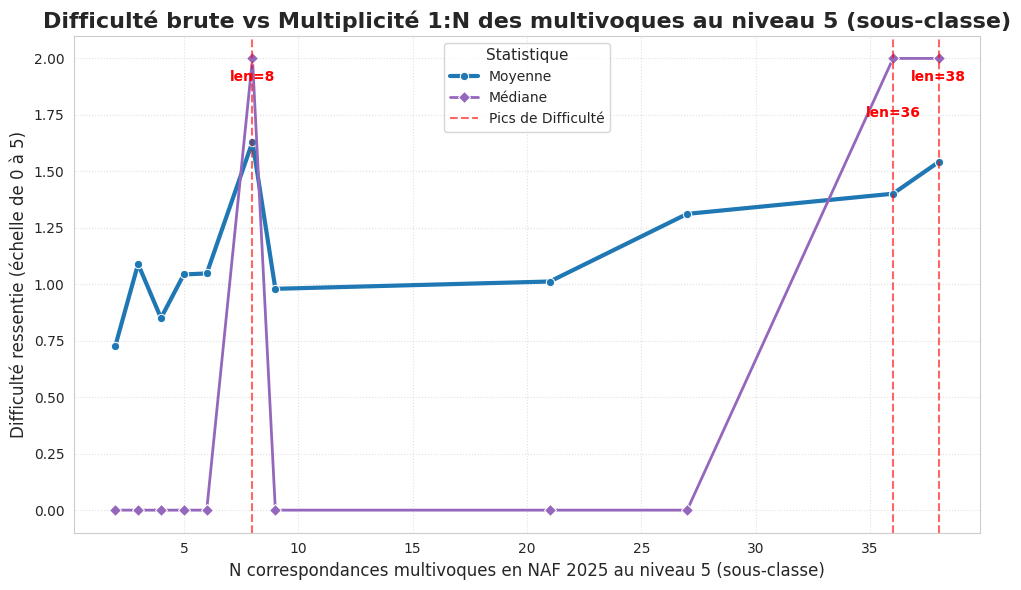

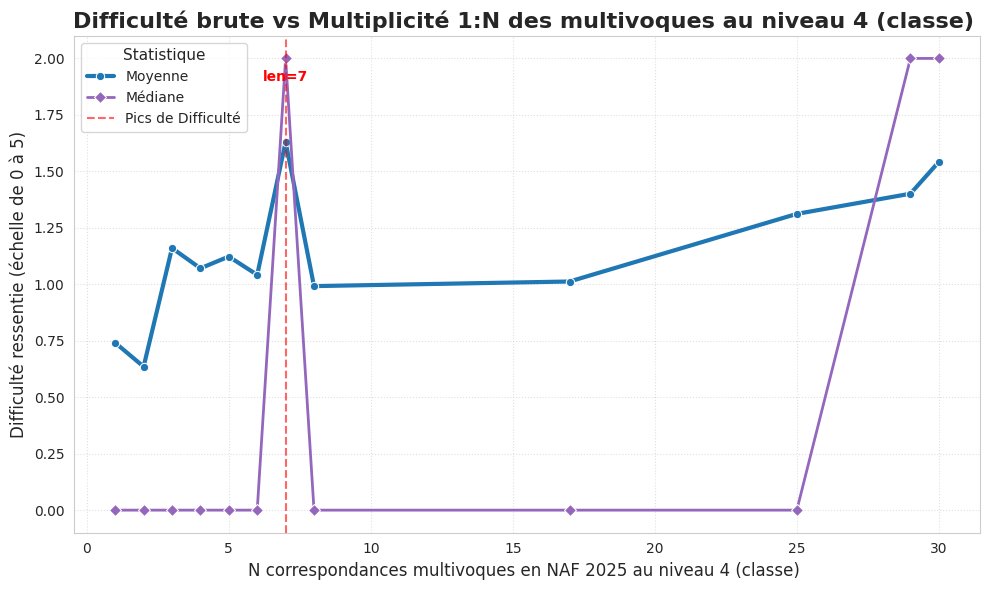

In [64]:
# Hypothèse de travail : Les DataFrames stats_niv5 et stats_niv4 contiennent ['len', 'Moyenne', 'Mediane'].

# --- Calcul des Pics (Plusieurs stratégies possibles) ---

print("--- Calcul des Pics pour le Niveau 5 ---")
# Stratégie A: Pics de Médiane (la plus pertinente si la baseline est 0.0)
longueurs_pics_5 = identifier_pics_dynamiques(
    stats_niv5, 
    colonne_a_analyser='Mediane',
    seuil_fixe=0.0 # Car on cherche tous les cas où la Médiane est > 0.0
)

print("\n--- Calcul des Pics pour le Niveau 4 ---")
# Stratégie B: Pics de Moyenne (méthode écart-type standard)
longueurs_pics_4 = identifier_pics_dynamiques(
    stats_niv4, 
    colonne_a_analyser='Moyenne',
    ecart_type_multiplicateur=1.5 # Utiliser 1.5 pour un seuil plus strict, par exemple
)

print(f"\nLongueurs pics Niv 5 (Mediane > 0.0) : {longueurs_pics_5}")
print(f"Longueurs pics Niv 4 (Moyenne + 1.5*std) : {longueurs_pics_4}")


# --- Visualisation Modulaire ---
# Utilisez votre fonction de plotting (plot_rating_vs_len)

plot_rating_vs_len(stats_niv5, "au niveau 5 (sous-classe)", longueurs_pics_5)
plot_rating_vs_len(stats_niv4, "au niveau 4 (classe) ", longueurs_pics_4)

--- Calcul des Pics pour le Niveau 5: CAS INCLASSABLES ---
  > Seuil de pic utilisé pour 'Mediane': Seuil Fixe = 0.0

--- Calcul des Pics pour le Niveau 4: CAS INCLASSABLES ---
  > Seuil de pic utilisé pour 'Moyenne': 1.060 + 1.5*std = 1.542

Longueurs pics Niv 5 (Mediane > 0.0) : [8]
Longueurs pics Niv 4 (Moyenne + 1.5*std) : [7]


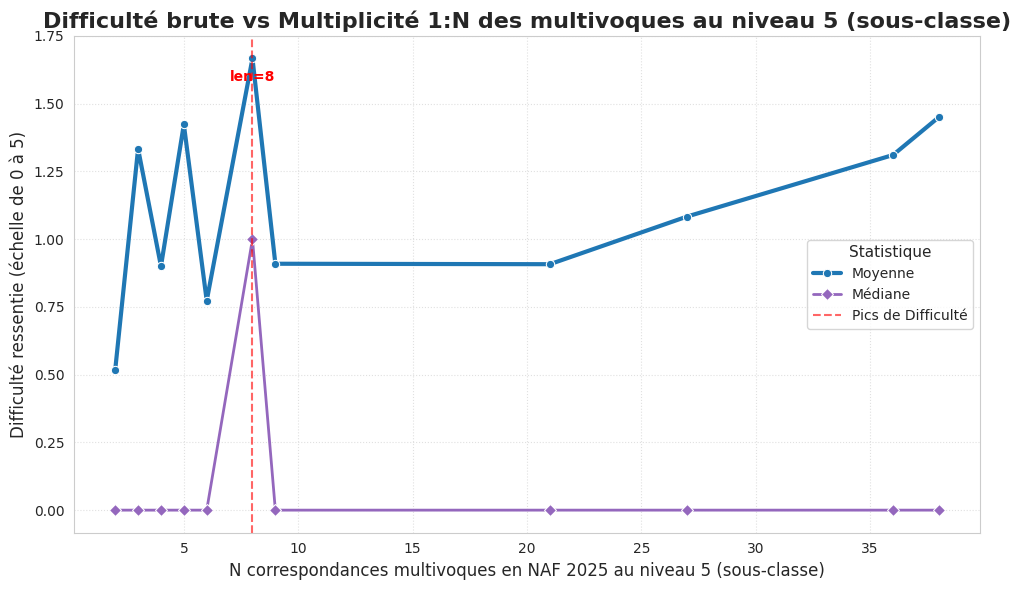

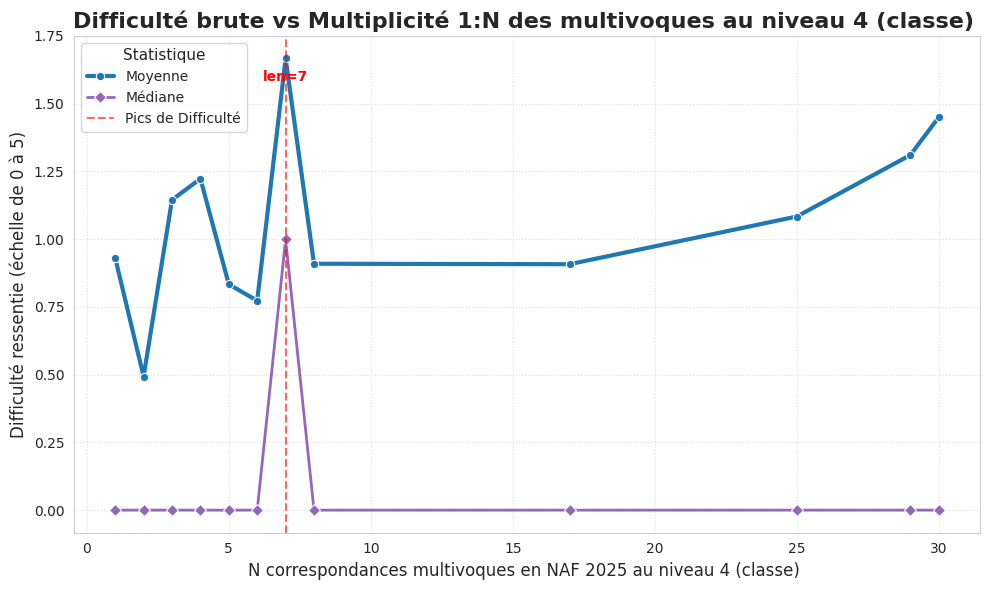

In [65]:
# Hypothèse de travail : Les DataFrames stats_niv5 et stats_niv4 contiennent ['len', 'Moyenne', 'Mediane'].

# --- Calcul des Pics (Plusieurs stratégies possibles) ---

print("--- Calcul des Pics pour le Niveau 5: CAS INCLASSABLES ---")
# Stratégie A: Pics de Médiane (la plus pertinente si la baseline est 0.0)
longueurs_pics_5 = identifier_pics_dynamiques(
    stats_niv5_unc_data, 
    colonne_a_analyser='Mediane',
    seuil_fixe=0.0 # Car on cherche tous les cas où la Médiane est > 0.0
)

print("\n--- Calcul des Pics pour le Niveau 4: CAS INCLASSABLES ---")
# Stratégie B: Pics de Moyenne (méthode écart-type standard)
longueurs_pics_4 = identifier_pics_dynamiques(
    stats_niv4_unc_data, 
    colonne_a_analyser='Moyenne',
    ecart_type_multiplicateur=1.5 # Utiliser 1.5 pour un seuil plus strict, par exemple
)

print(f"\nLongueurs pics Niv 5 (Mediane > 0.0) : {longueurs_pics_5}")
print(f"Longueurs pics Niv 4 (Moyenne + 1.5*std) : {longueurs_pics_4}")


# --- Visualisation Modulaire ---
# Utilisez votre fonction de plotting (plot_rating_vs_len)

plot_rating_vs_len(stats_niv5_unc_data, "au niveau 5 (sous-classe)", longueurs_pics_5)
plot_rating_vs_len(stats_niv4_unc_data, "au niveau 4 (classe) ", longueurs_pics_4)

Les courbes sont quasi-identiques entre le niveau 4 et le niveau 5.
Le raisonnement est similaire mais avec des abscisses différentes.

In [66]:
comparison_stats_niv5_niv4 = pd.merge(
    stats_niv5, 
    stats_niv4, 
    on='len', 
    how='inner',  # On ne compare que les longueurs communes aux deux niveaux: toujours le cas
    suffixes=('_niv5', '_niv4')
)

# --- Corrélation pour la Moyenne ---
correlation_moyenne = comparison_stats_niv5_niv4['Moyenne_niv5'].corr(
    comparison_stats_niv5_niv4['Moyenne_niv4'], 
    method='pearson'
)

# --- Corrélation pour la Proportion de Difficulté ---
correlation_proportion = comparison_stats_niv5_niv4['Part_difficiles_niv5'].corr(
    comparison_stats_niv5_niv4['Part_difficiles_niv4'], 
    method='pearson'
)

print(f"Corrélation de Pearson (Moyenne du Rating) : {correlation_moyenne:.4f}")
print(f"Corrélation de Pearson (Proportion de cas difficiles) : {correlation_proportion:.4f}")

Corrélation de Pearson (Moyenne du Rating) : 0.3549
Corrélation de Pearson (Proportion de cas difficiles) : 0.1710


In [67]:
def plot_proportion_difficulte(stats_df, title_level, longueurs_pics):
    """
    Trace la Proportion de Difficulté (part des cas >= 3) en fonction de la longueur,
    avec des lignes verticales pour les abscisses des pics.
    """
    
    # Configuration du style Seaborn
    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 7)) # Légèrement plus grand pour l'annotation
    
    # --- 1. Tracé de la Proportion de Difficulté (Métrique principale) ---
    sns.lineplot(x='len', y='Part_difficiles', data=stats_df, marker='o', 
                 label='Proportion de cas jugés difficiles (Rating > 3)', 
                 linewidth=3, color='#d62728')

    # --- AJOUT DYNAMIQUE DES LIGNES VERTICALES ET ANNOTATIONS ---
    # La valeur maximale est 1.0 car c'est une proportion
    max_y_value = 1.0
    
    for i, pic_len in enumerate(longueurs_pics):
        # 1. Dessiner la ligne verticale
        plt.axvline(x=pic_len, color='red', linestyle='--', linewidth=1.5, alpha=0.6, 
                    label='Pics de Fréquence' if i == 0 else None)
        
        # 2. Annoter la ligne
        # Nous utilisons la valeur de la proportion au point du pic pour le positionnement Y
        # Si la longueur pic n'est pas dans le DF (rare mais possible), on utilise 0.95
        try:
            pic_value = stats_df[stats_df['len'] == pic_len]['Part_difficiles'].iloc[0]
        except:
            pic_value = max_y_value * 0.9
            
        plt.text(pic_len, 
                 max_y_value * 0.95 - (i % 2) * (max_y_value * 0.08), # Position Y alternée
                 f'len={pic_len} ({pic_value:.2f})', 
                 color='red', 
                 fontsize=10, 
                 fontweight='bold',
                 ha='center')

    # --- Titres et étiquettes ---
    plt.title(f'Part de jugés difficiles vs Multiplicité 1:N des multivoques {title_level}', 
              fontsize=16, fontweight='bold')
    plt.xlabel(f"Nombre de correspondances multivoques en NAF 2025 (Complexité)", fontsize=12)
    plt.ylabel("Proportion de Cas Jugés Difficiles (0 à 1)", fontsize=12)
    
    # Affichage de la légende complète
    plt.legend(title='Métrique', title_fontsize='11', loc='upper left')
    
    plt.ylim(0, max_y_value * 1.05) # S'assurer que l'axe Y va jusqu'à 1
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

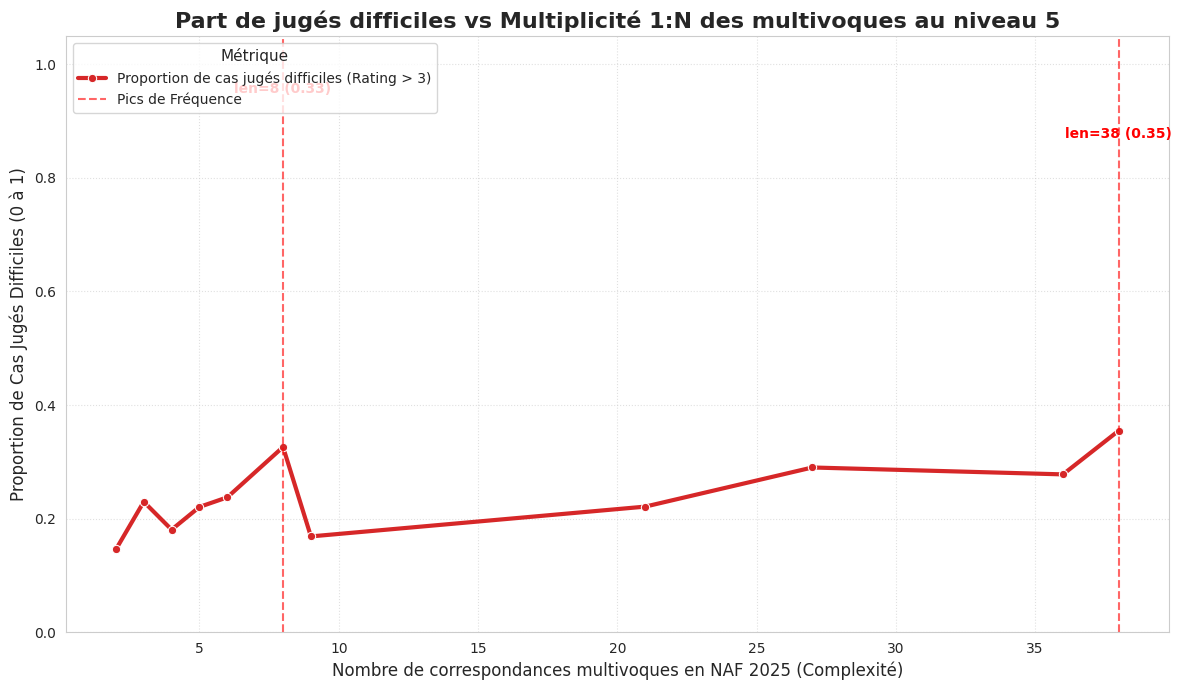

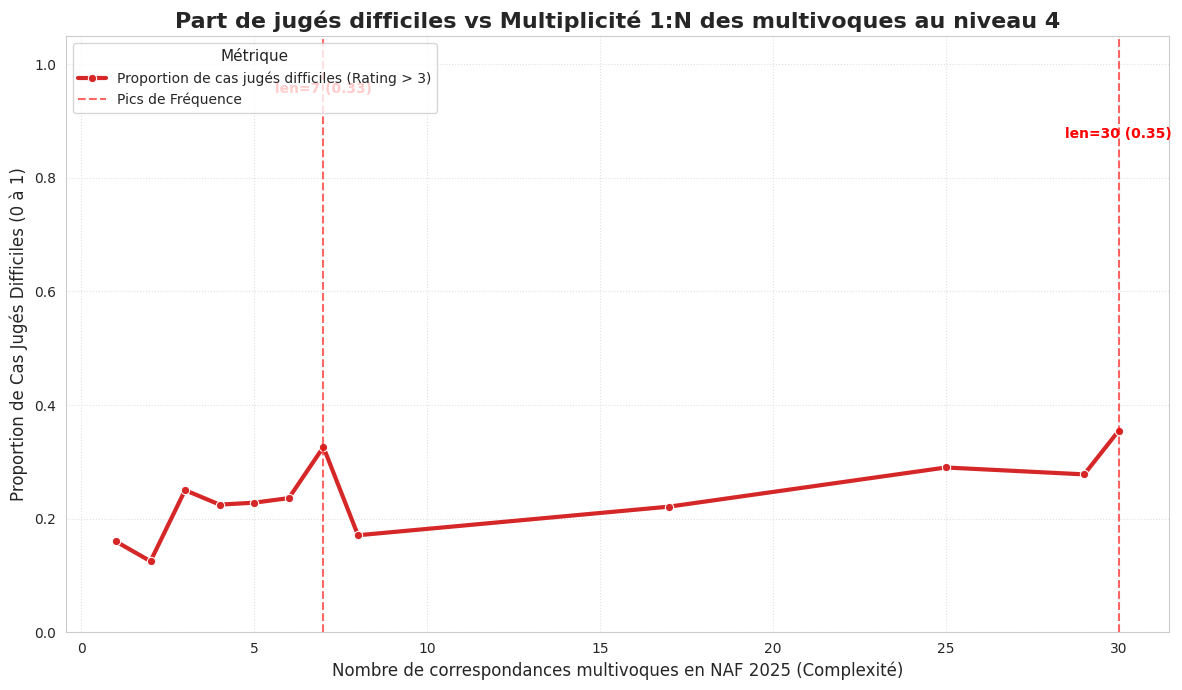

In [68]:
# --- Graphique 1 : Niveau 5 ---

# Critère de pic
mean_baseline_5 = stats_niv5['Part_difficiles'].mean() # Utilisez la colonne correcte
std_variation_5 = stats_niv5['Part_difficiles'].std()
SEUIL_PIC_5 = mean_baseline_5 + (1 * std_variation_5)
longueurs_pics_5 = stats_niv5[stats_niv5['Part_difficiles'] >= SEUIL_PIC_5]['len'].tolist()

mean_baseline_4 = stats_niv4['Part_difficiles'].mean() # Utilisez la colonne correcte
std_variation_4 = stats_niv4['Part_difficiles'].std()
SEUIL_PIC_4 = mean_baseline_4 + (1 * std_variation_4)
longueurs_pics_4 = stats_niv4[stats_niv4['Part_difficiles'] >= SEUIL_PIC_4]['len'].tolist()

# 2. Visualisation
plot_proportion_difficulte(stats_niv5, "au niveau 5", longueurs_pics_5)
plot_proportion_difficulte(stats_niv4, "au niveau 4", longueurs_pics_4)

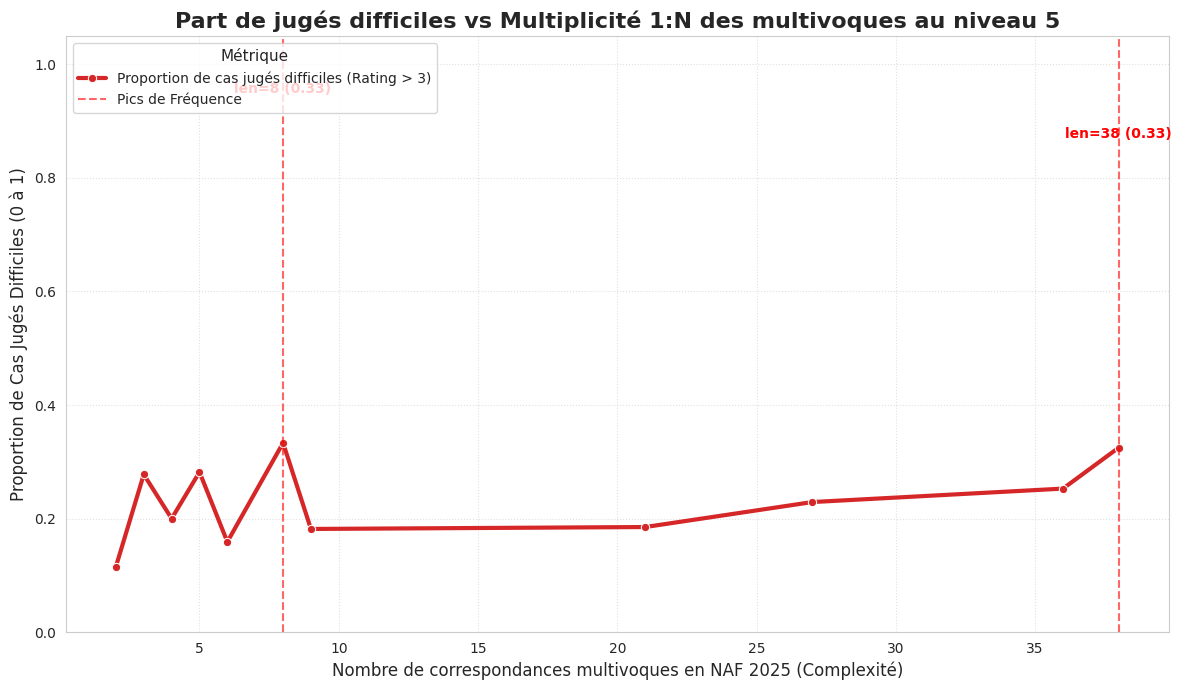

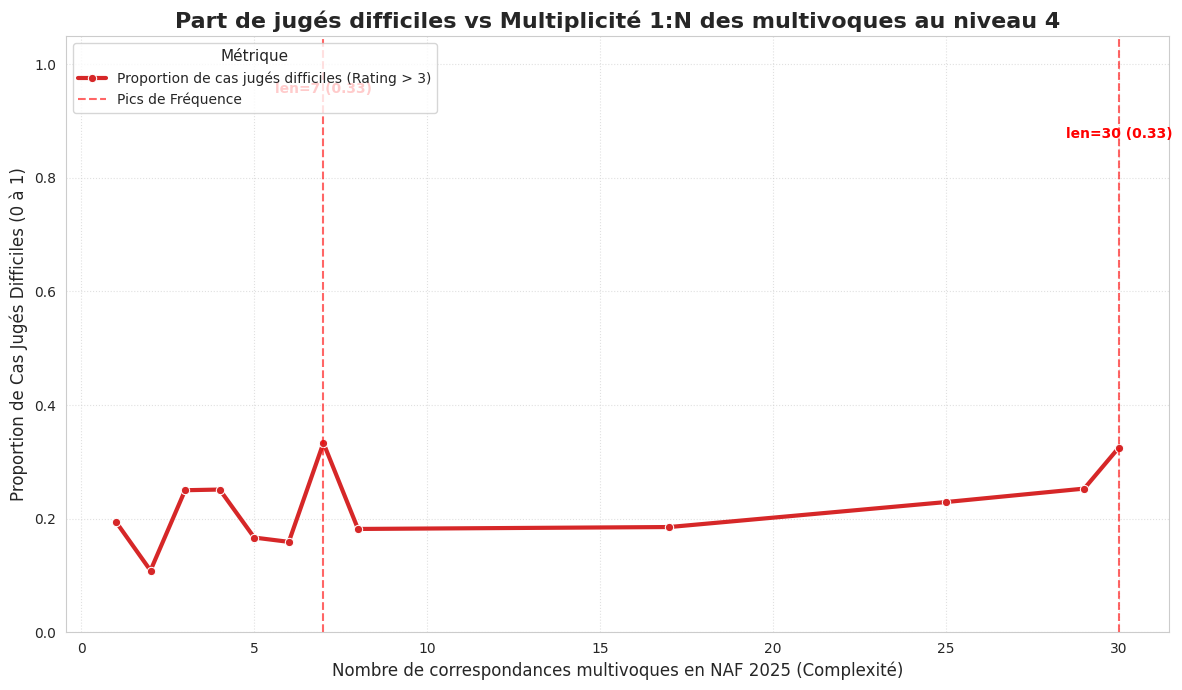

In [69]:
# --- Graphique 1 : Niveau 5 ---

# Critère de pic
mean_baseline_5 = stats_niv5_unc_data['Part_difficiles'].mean() # Utilisez la colonne correcte
std_variation_5 = stats_niv5_unc_data['Part_difficiles'].std()
SEUIL_PIC_5 = mean_baseline_5 + (1 * std_variation_5)
longueurs_pics_5 = stats_niv5_unc_data[stats_niv5_unc_data['Part_difficiles'] >= SEUIL_PIC_5]['len'].tolist()

mean_baseline_4 = stats_niv4_unc_data['Part_difficiles'].mean() # Utilisez la colonne correcte
std_variation_4 = stats_niv4_unc_data['Part_difficiles'].std()
SEUIL_PIC_4 = mean_baseline_4 + (1 * std_variation_4)
longueurs_pics_4 = stats_niv4_unc_data[stats_niv4_unc_data['Part_difficiles'] >= SEUIL_PIC_4]['len'].tolist()

# 2. Visualisation
plot_proportion_difficulte(stats_niv5_unc_data, "au niveau 5", longueurs_pics_5)
plot_proportion_difficulte(stats_niv4_unc_data, "au niveau 4", longueurs_pics_4)

Même pour les cas inclassables, on retrouve le même phénomène. 
Avoir beaucoup de cas multivoques n'augmentent pas la part de tâches difficiles.
A partir de 20 correspondances possibles, la difficulté augmente progressivement.
seuil de difficulté autour de 30 options (niv4) et 35 niv5

Entre 10 et 20 options, la difficulté perçue par les répondants reste globalement stable. À partir d’une vingtaine de choix, on observe une montée progressive de la charge cognitive, qui s’accentue nettement autour de 30 (niv4) et 35 au niv5. On atteint seuil de charge cognitive — ou, plus largement, d’un effet de seuil psychologique.
